# Data augmentation
- Artificiellt skapa fler bilder
- slumpmässigt:
    - Roterar till en viss grad (radianer)
    - Traslatera
    - flippa horisontellt, vertiklat (Spegla)
    - Shear
    - ...

11501568/11490434 [==============================] - 0s 0us/step


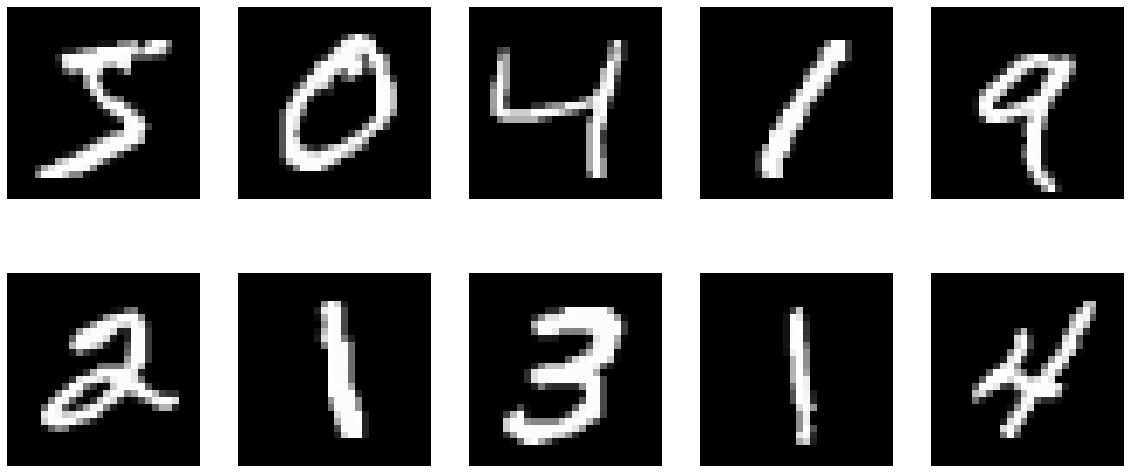

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2,5, figsize = (20,9))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)
        

In [2]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train | Val | Test split

In [3]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

## Data augmentation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range = 10,
    shear_range = .2,
    zoom_range = .1,
    horizontal_flip = False,
    height_shift_range = .2,
    width_shift_range = .2
)

# Dont augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size = 32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x7f7b4fa44cd0>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x7f7b4f9c8a50>)

2
(32, 28, 28, 1)


array([1, 5, 9, 6, 5, 0, 1, 3, 5, 5, 0, 6, 9, 7, 8, 2, 3, 8, 4, 0, 2, 7,
       9, 7, 6, 6, 6, 2, 4, 0, 2, 3], dtype=uint8)

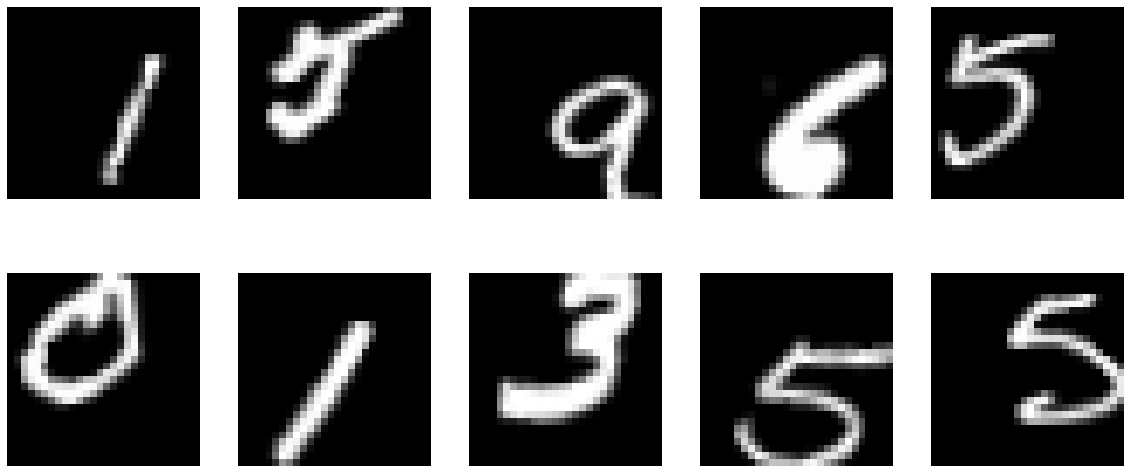

In [5]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) ## 32 smaples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

## CNN model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name = "CNN_model")

    ## The Convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), 
                            activation = "relu", kernel_initializer = "he_normal", 
                            input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               20

2022-04-28 08:16:14.689020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:16:14.808078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:16:14.808837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:16:14.810025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Train and Augment data

In [9]:
steps_per_epoch = int(len(X_train_val)/32)
validation_steps = int(len(X_val)/32)

steps_per_epoch, validation_steps

(1562, 312)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_acc", mode="max", patience = 5,restore_best_weights = True)

model.fit(
    train_val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    callbacks = [early_stopper],
    validation_data = val_generator,
    validation_steps = validation_steps
)

2022-04-28 08:23:55.286383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-28 08:23:56.488321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1562/1562 [==============================] - 25s 12ms/step - loss: 0.6389 - acc: 0.7909 - val_loss: 0.1372 - val_acc: 0.9580
Epoch 2/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2552 - acc: 0.9195 - val_loss: 0.0729 - val_acc: 0.9783
Epoch 3/100
1562/1562 [==============================] - 18s 12ms/step - loss: 0.2000 - acc: 0.9370 - val_loss: 0.0647 - val_acc: 0.9801
Epoch 4/100
1562/1562 [==============================] - 18s 11ms/step - loss: 0.1760 - acc: 0.9439 - val_loss: 0.0521 - val_acc: 0.9847
Epoch 5/100
1562/1562 [==============================] - 20s 13ms/step - loss: 0.1576 - acc: 0.9507 - val_loss: 0.0539 - val_acc: 0.9824
Epoch 6/100
1562/1562 [==============================] - 19s 12ms/step - loss: 0.1491 - acc: 0.9534 - val_loss: 0.0516 - val_acc: 0.9841
Epoch 7/100
1562/1562 [==============================] - 18s 11ms/step - loss: 0.1400 - acc: 0.9557 - val_loss: 0.0502 - val_acc: 0.9842
Epoch 8/100
1562/1562 [==============================

In [13]:
metrics = pd.DataFrame(model.history.history)

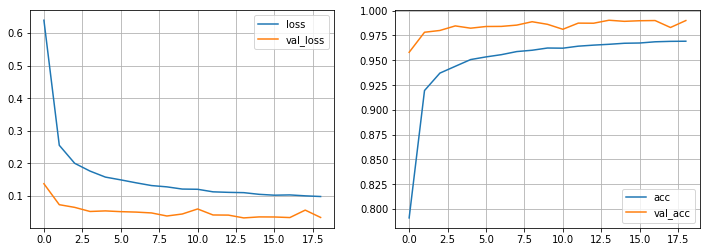

In [14]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2,figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax=ax[0], grid=True)
    metrics[["acc", "val_acc"]].plot(ax=ax[1], grid = True)
    
plot_metrics(metrics)

## Train on all training data

In [17]:
train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)

In [21]:
model = CNN_model()
model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 16)

Epoch 1/16
1562/1562 [==============================] - 16s 10ms/step - loss: 0.6318 - acc: 0.7921
Epoch 2/16
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2736 - acc: 0.9135
Epoch 3/16
1562/1562 [==============================] - 16s 10ms/step - loss: 0.2153 - acc: 0.9319
Epoch 4/16
1562/1562 [==============================] - 16s 11ms/step - loss: 0.1860 - acc: 0.9417
Epoch 5/16
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1663 - acc: 0.9472
Epoch 6/16
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1541 - acc: 0.9513
Epoch 7/16
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1458 - acc: 0.9547
Epoch 8/16
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1358 - acc: 0.9562
Epoch 9/16
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1353 - acc: 0.9584
Epoch 10/16
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1286 - acc: 0.9600
Epoch 11/

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



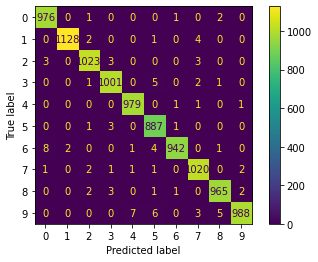

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()